In [20]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
from obspy import read
from obspy.signal.filter import bandpass
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define data directories
TRAIN_DATA_DIR = './data/lunar/training/data/S12_GradeA/'
TRAIN_CATALOG_FILE = './data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv'
TEST_DATA_DIR = './data/lunar/test/data/S12_GradeB/'

# Load the training catalog
catalog = pd.read_csv(TRAIN_CATALOG_FILE)


In [21]:
# Function to load seismic data from a file
def load_seismic_data(filename, data_dir=TRAIN_DATA_DIR):
    mseed_file = os.path.join(data_dir, filename + '.mseed')
    st = read(mseed_file)
    tr = st[0]
    data = tr.data
    sampling_rate = tr.stats.sampling_rate
    starttime = tr.stats.starttime.datetime
    return data, sampling_rate, starttime

# Prepare lists to hold data and labels
X = []
y = []

# Parameters for data segmentation
WINDOW_SIZE = 1024  # Number of samples per segment (adjust as needed)
STEP_SIZE = 256     # Step size for sliding window (adjust as needed)
EVENT_WINDOW_LABEL = 1
NO_EVENT_WINDOW_LABEL = 0

# Bandpass filter parameters (adjust as needed)
FREQ_MIN = 0.5  # Hz
FREQ_MAX = 2.0  # Hz

# Load data and labels
for idx, row in catalog.iterrows():
    filename = row['filename']
    arrival_time_rel = row['time_rel(sec)']
    # Load seismic data
    data, sampling_rate, starttime = load_seismic_data(filename)
    # Apply bandpass filter
    data = bandpass(data, FREQ_MIN, FREQ_MAX, sampling_rate, corners=4, zerophase=True)
    # Normalize data
    data = (data - np.mean(data)) / np.std(data)
    # Calculate event sample index
    event_sample_idx = int(arrival_time_rel * sampling_rate)
    # Slide a window over the data
    num_segments = (len(data) - WINDOW_SIZE) // STEP_SIZE + 1
    for i in range(num_segments):
        start_idx = i * STEP_SIZE
        end_idx = start_idx + WINDOW_SIZE
        window_data = data[start_idx:end_idx]
        # Check if the event is within this window
        if event_sample_idx >= start_idx and event_sample_idx < end_idx:
            label = EVENT_WINDOW_LABEL
        else:
            label = NO_EVENT_WINDOW_LABEL
        # Append to lists
        X.append(window_data)
        y.append(label)

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)
print(f'Total segments: {len(X)}')


Total segments: 168377


In [22]:
for idx, row in catalog.iterrows():
    filename = row['filename']
    arrival_time_rel = row['time_rel(sec)']
    # Load seismic data
    data, sampling_rate, starttime = load_seismic_data(filename)
    # Apply bandpass filter
    data = bandpass(data, FREQ_MIN, FREQ_MAX, sampling_rate, corners=4, zerophase=True)
    # Normalize data
    data = (data - np.mean(data)) / np.std(data)
    # Calculate event sample index
    event_sample_idx = int(arrival_time_rel * sampling_rate)
    print(event_sample_idx)
    print(len(data))
    break

486937
572415


In [23]:
# Count the number of samples in each class
unique, counts = np.unique(y, return_counts=True)
print(f'Class distribution before balancing: {dict(zip(unique, counts))}')

# Oversample the minority class
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X.reshape(-1, WINDOW_SIZE), y)

print(f'Class distribution after balancing: {dict(zip(*np.unique(y_resampled, return_counts=True)))}')

# Reshape X for CNN input (samples, timesteps, channels)
#X_resampled = X_resampled[..., np.newaxis]


Class distribution before balancing: {0: 168073, 1: 304}
Class distribution after balancing: {0: 168073, 1: 168073}


In [24]:
X = X.reshape(-1, WINDOW_SIZE)# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y_resampled
)

print(f'Training data shape: {X_train.shape}')
print(f'Validation data shape: {X_val.shape}')


ValueError: Found input variables with inconsistent numbers of samples: [168377, 336146]

In [9]:
# import xgboost as xgb
# from xgboost import XGBClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# model = XGBClassifier()
# # Train the model
# model.fit(X_train, y_train)
# # Make predictions
# y_pred = model.predict(X_val)
# # Evaluate the model's accuracy
# accuracy = accuracy_score(y_val, y_pred)
# print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.9999


In [14]:
# Build a 1D CNN model
model = models.Sequential([
    layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(WINDOW_SIZE, 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.summary()


C:\Users\kgenk\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2046, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1023, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1021, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 510, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 508, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,361 (153.75 KB)

 Trainable params: 39,361 (153.75 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Add callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)


Epoch 1/5
 747/2094 ━━━━━━━━━━━━━━━━━━━━ 1:51 82ms/step - accuracy: 0.6788 - loss: 0.5970

KeyboardInterrupt: 

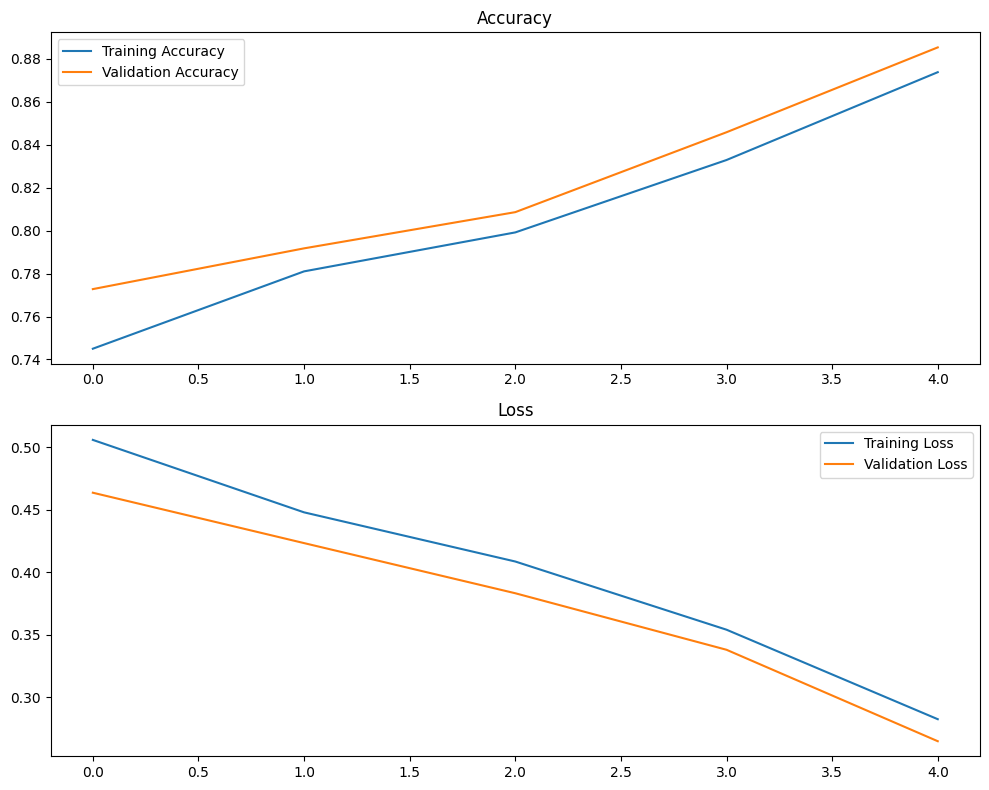

In [8]:
# Plot training and validation accuracy and loss
def plot_history(history):
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))
    # Accuracy plot
    axs[0].plot(history.history['accuracy'], label='Training Accuracy')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[0].set_title('Accuracy')
    axs[0].legend()
    # Loss plot
    axs[1].plot(history.history['loss'], label='Training Loss')
    axs[1].plot(history.history['val_loss'], label='Validation Loss')
    axs[1].set_title('Loss')
    axs[1].legend()
    plt.tight_layout()
    plt.show()

plot_history(history)


In [9]:
# Evaluate on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

# Classification report
y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()
print(classification_report(y_val, y_pred))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
print('Confusion Matrix:')
print(cm)


1047/1047 [==============================] - 6s 5ms/step - loss: 0.2650 - accuracy: 0.8854
Validation Accuracy: 88.54%
1047/1047 [==============================] - 6s 5ms/step
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     16749
           1       0.89      0.89      0.89     16749

    accuracy                           0.89     33498
   macro avg       0.89      0.89      0.89     33498
weighted avg       0.89      0.89      0.89     33498

Confusion Matrix:
[[14828  1921]
 [ 1919 14830]]


In [17]:
# Function to process test data
def process_test_data(test_filename, data_dir=TEST_DATA_DIR):
    # Load data
    data, sampling_rate, starttime = load_seismic_data(test_filename, data_dir)
    # Apply bandpass filter
    data = bandpass(data, FREQ_MIN, FREQ_MAX, sampling_rate, corners=4, zerophase=True)
    # Normalize data
    data = (data - np.mean(data)) / np.std(data)
    # Segment data
    segments = []
    segment_times = []
    num_segments = (len(data) - WINDOW_SIZE) // STEP_SIZE + 1
    for i in range(num_segments):
        start_idx = i * STEP_SIZE
        end_idx = start_idx + WINDOW_SIZE
        window_data = data[start_idx:end_idx]
        segments.append(window_data)
        # Calculate the midpoint time of the window
        window_start_time = starttime + timedelta(seconds=start_idx / sampling_rate)
        window_mid_time = window_start_time + timedelta(seconds=(WINDOW_SIZE / (2 * sampling_rate)))
        segment_times.append(window_mid_time)
    # Convert to numpy array and reshape
    segments = np.array(segments)
    segments = segments[..., np.newaxis]
    return segments, segment_times

# List of test files
test_files = [f.replace('.mseed', '') for f in os.listdir(TEST_DATA_DIR) if f.endswith('.mseed')]

# Prepare a list to hold detections before converting to DataFrame
detections_list = []

# Loop over test files
for test_filename in test_files:
    segments, segment_times = process_test_data(test_filename)
    # Make predictions
    predictions = model.predict(segments)
    # Threshold predictions
    predicted_labels = (predictions > 0.5).astype("int32").flatten()
    # Extract times where events are detected
    event_indices = np.where(predicted_labels == 1)[0]
    for idx in event_indices:
        event_time = segment_times[idx]
        # Convert to required string format
        event_time_str = event_time.strftime('%Y-%m-%dT%H:%M:%S.%f')
        # Calculate relative time in seconds from start of file
        time_rel_sec = (event_time - segment_times[0]).total_seconds()
        # Append the detection to the list
        detections_list.append({
            'filename': test_filename,
            'time_abs(%Y-%m-%dT%H:%M:%S.%f)': event_time_str,
            'time_rel(sec)': time_rel_sec
        })

# Convert the list of detections to a DataFrame
detections = pd.DataFrame(detections_list)


35/35 [==============================] - 0s 6ms/step


In [18]:
# Save the detections to a CSV file
detections.to_csv('seismic_event_detections.csv', index=False)
print('Detections saved to seismic_event_detections.csv')


Detections saved to seismic_event_detections.csv
